# 2021/12/28
# 本代码绘制version1.1中的垂直纬向风场的uvw图
# 包含内容有辐合辐散、经向风、u-w风场

In [11]:
import os
import sys
import xarray as xr
import numpy as np
module_path = ["/home/sun/mycode/module/","/data5/2019swh/mycode/module/"]
sys.path.append(module_path[0])
from module_sun import *
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from metpy.units import units
from matplotlib.path import Path
import matplotlib.patches as patches

import warnings
warnings.filterwarnings("ignore")

path =   "/home/sun/qomo-data/"
lon_slice  =  slice(50,120)
lat_slice  =  slice(10,15)
lev_slice  =  slice(1000,200)

f1   =   xr.open_dataset(path+"composite_equivalent_tem.nc").sel(lon=lon_slice,lat=lat_slice,level=lev_slice).isel(time=slice(0,30))

theta1      =  f1.theate_e
avg_theta   =  np.average(np.average(theta1,axis=0),axis=1)

f2     =  xr.open_dataset("/home/sun/qomo-data/composite3.nc").sel(lat=slice(10,15),lon=lon_slice,level=lev_slice)
uwind  =  np.nanmean(f2.uwind,axis=2)
vwind  =  np.nanmean(f2.vwind,axis=2)
omega  =  np.nanmean(f2.OMEGA,axis=2)*-60


# 计算散度
f4   =   xr.open_dataset(path+"composite-div_vor.nc").sel(lat=slice(10,15),lon=lon_slice,level=lev_slice)
div  =   np.nanmean(f4.div,axis=2)

# 计算地形
f5   =   xr.open_dataset("/home/sun/data/gebco/bathymetric.nc").sel(lat=slice(10,15),lon=lon_slice)
dixing  =  f5.elevation.data
dixing[dixing <= 0]  =  0
topo    =  np.average(dixing,axis=0)

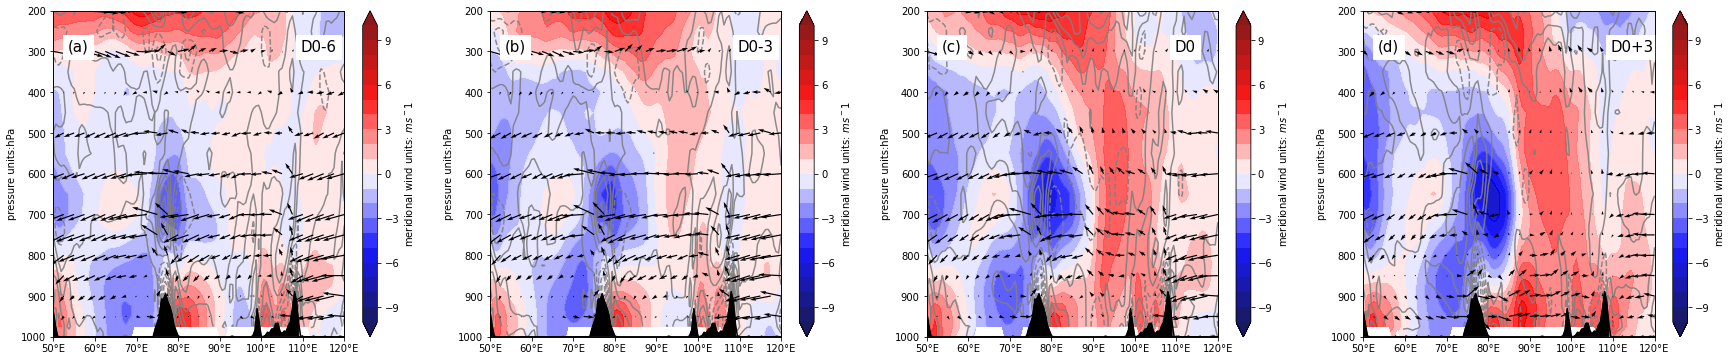

In [12]:
days = ["D0-6","D0-3","D0","D0+3"]
dd  =  [24,27,30,33]
number =  ["a","b","c","d"]
props = dict(boxstyle='square', edgecolor='white', facecolor='white', alpha=1)
# 创建画布
fig  =  plt.figure(figsize=(30,6))
spec =  fig.add_gridspec(nrows=1,ncols=4)

j  =  0
for col in range(4):
    ax   =  fig.add_subplot(spec[0,col])
    ax.invert_yaxis()

    # 绘制等值线
    im1   =  ax.contour(f1.lon,f1.level,div[dd[j],:],10,linewidth=0.9,colors='grey',negative_linestyle='dashed',zorder=1,alpha=0.9)
    im2   =  ax.contourf(f4.lon,f4.level,vwind[dd[j],:],np.linspace(-10,10,21),cmap='seismic',extend='both',alpha=0.9,zorder=0)
    q  =  ax.quiver(f2.lon[::4], f2.level[::2], uwind[dd[j],::2,::4], omega[dd[j],::2,::4], 
                    angles='uv',# regrid_shape这个参数越小，是两门就越稀疏
                    scale_units='xy', scale=1.1,        # scale是参考矢量，所以取得越大画出来的箭头就越短
                    units='xy', width=2.2,
                    color='k',zorder=2)
    fig.colorbar(im2,label='meridional wind units: ${m s^-1}$')

    ax.set_xticklabels(generate_lon_label(50,120,10))

    ax.set_ylabel("pressure units:hPa")

    ax.text(0.85,0.875,days[j],transform=ax.transAxes,bbox=props,fontsize=15)
    ax.text(0.05,0.875,"("+number[j]+")",transform=ax.transAxes,bbox=props,fontsize=15)

    # 添加地形
    ax2  =  ax.twinx()
    ax2.set_ylim((0,4.5))
    #ax2.set_yticks(np.arange(0,21,1))
    ax2.plot(f5.lon.data,topo/1000,color='k')
    ax2.fill_between(f5.lon.data,0,topo/1000,where=topo>0,color='k')

    ax2.set_yticklabels([])
    ax2.set_yticks([])

    j+=1


plt.savefig("/home/sun/paint/lunwen/version1.1/fig6b_version1.1_div_vwind_vector.pdf",dpi=350)